In [1]:
# requires seaborn, pandas

In [2]:
import uuid
from datetime import datetime
import logging

import seaborn as sns
import pandas as pd
import dns.message
import dns.query
import dns.flags
from dns.rdatatype import SOA, TXT, RRSIG, A, AAAA
from dns.rdataclass import IN

logging.basicConfig(level=logging.ERROR, force=True)

sns.set_style('whitegrid')

def query(qname, rdtype) -> dns.message.Message:
    q = dns.message.make_query(
        qname=qname, rdtype=rdtype, want_dnssec=False, use_edns=0,
    )
    q.flags |= dns.flags.AD
    logging.debug(q.to_text())
    start = datetime.now()
    r = dns.query.udp(q, where='127.0.0.1', port=5302)  # local recursor
    return r, (datetime.now() - start).total_seconds()

In [3]:
def random_query(algorithm):
    qname = dns.name.from_text(f"{str(uuid.uuid4())}.{algorithm}.example.")
    rdtype = TXT
    r, query_time = query(qname, rdtype)
    assert dns.flags.AD in r.flags
    assert len(r.get_rrset(dns.message.ANSWER, qname, IN, rdtype)) > 0
    return {
        'algorithm': algorithm,
        'query_time': query_time,
    }

In [4]:
# tested algorithms
ALGORITHMS = {
    5: "rsasha1", 8: "rsasha256", 10: "rsasha512",  # pdns also supports 7: "rsasha1-nsec3-sha1",
    13: "ecdsa256", 14: "ecdsa384",
    15: "ed25519", 16: "ed448",
    17: "falcon",
}

In [5]:
# warm up cache
[random_query(algorithm) for algorithm in ALGORITHMS.values()]

[{'algorithm': 'rsasha1', 'query_time': 0.004214},
 {'algorithm': 'rsasha256', 'query_time': 0.002351},
 {'algorithm': 'rsasha512', 'query_time': 0.002098},
 {'algorithm': 'ecdsa256', 'query_time': 0.002559},
 {'algorithm': 'ecdsa384', 'query_time': 0.01317},
 {'algorithm': 'ed25519', 'query_time': 0.002349},
 {'algorithm': 'ed448', 'query_time': 0.006677},
 {'algorithm': 'falcon', 'query_time': 0.003187}]

In [6]:
# test configuration
samples = 10000

In [7]:
# do measurements
query_times = pd.DataFrame(
    [random_query(algorithm) for _ in range(samples) for algorithm in ALGORITHMS.values()]
)

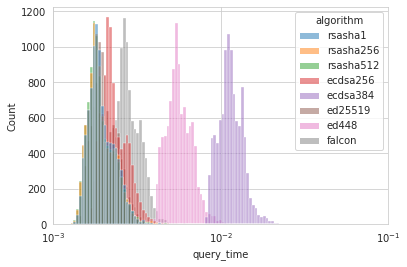

In [8]:
# visualize
g = sns.histplot(
    query_times,
    x='query_time', hue='algorithm', 
    log_scale=(True, False),
)
g.set(xlim=(1*1e-3, 1e-1))
None

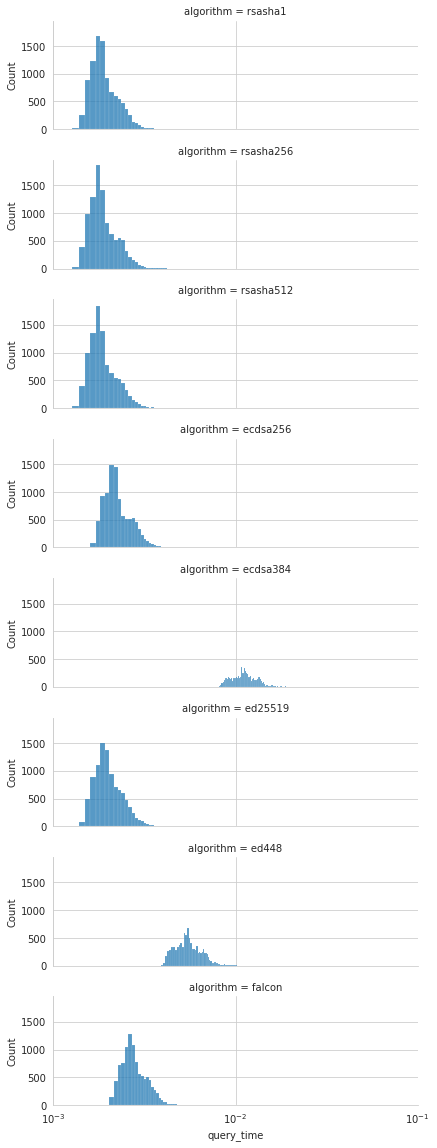

In [9]:
# visualize
g = sns.displot(
    data=query_times,
    x='query_time', row='algorithm', 
    kind='hist',
    aspect=3, height=2,
)
g.set(xlim=(1*1e-3, 1e-1), xscale='log')
None